In [129]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import scipy.stats as stats
import matplotlib.pyplot as plt
from numpy import random

import particles
import particles.state_space_models as ssm
import particles.distributions as dists
from particles import collectors
from particles import multiSMC
import particles.mcmc as mcmc
import particles.smc_samplers as ssp

In [130]:
#pip install particles

Let's implement the model in general case :

Data

First let's do a return only based study (Table A1: Parameter Estimates: Return-Based Estimation)

In [131]:
SP500_TICKER = '^GSPC'
FRED_TICKER = 'DTB3'

start_date = '1996-01-01'
end_date = '2015-12-31'

Trad_days_year = 252

In [132]:
data_SP500 = yf.download(SP500_TICKER, start=start_date, end=end_date, progress=False)
rf_data = web.DataReader(FRED_TICKER, 'fred', start=start_date, end=end_date)

C:\Users\bouch\AppData\Local\Temp\ipykernel_40772\1254190739.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_SP500 = yf.download(SP500_TICKER, start=start_date, end=end_date, progress=False)


In [133]:
data_SP500 = data_SP500[['Close']]
data_SP500.columns = ['S_t']
data_SP500['R_t'] = np.log(data_SP500['S_t']/data_SP500['S_t'].shift(1))#log-return
data_SP500

,S_t,R_t
Date,,
1996-01-02,620.729980,NaN
1996-01-03,621.320007,0.000950
1996-01-04,617.700012,-0.005843
1996-01-05,616.710022,-0.001604
1996-01-08,618.460022,0.002834
...,...,...
2015-12-23,2064.290039,0.012342
2015-12-24,2060.989990,-0.001600
2015-12-28,2056.500000,-0.002181


In [134]:
data_SP500.describe()

,S_t,R_t
count,5035.000000,5034.000000
mean,1262.186441,0.000239
std,338.454945,0.012342
min,598.479980,-0.094695
25%,1063.169983,-0.005361
50%,1230.130005,0.000617
75%,1411.200012,0.006165
max,2130.820068,0.109572


In [135]:
rf_data.describe()

,DTB3
count,5006.000000
mean,2.344754
std,2.150483
min,-0.020000
25%,0.110000
50%,1.690000
75%,4.780000
max,6.240000


In [136]:
len(rf_data)

5219

Fill the null value by the rf of the previous day,expect for the first january of 1996 we fill with the next day (as no previous day)

In [137]:
rf_data['DTB3'] = rf_data['DTB3'].fillna(method='ffill')
rf_data.loc['1996-01-01 00:00:00','DTB3'] = rf_data.loc['1996-01-02 00:00:00','DTB3']
rf_data.columns = ['rf_t']
rf_data['rf_t'] = rf_data['rf_t']/(100)#get rid of % #252 ?


C:\Users\bouch\AppData\Local\Temp\ipykernel_40772\1605616683.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_data['DTB3'] = rf_data['DTB3'].fillna(method='ffill')


In [138]:
data_return_based = pd.merge(rf_data, data_SP500, left_index=True, right_index=True, how='inner')
data_return_based = data_return_based.dropna()
data_return_based

,rf_t,S_t,R_t
1996-01-03,0.0505,621.320007,0.000950
1996-01-04,0.0504,617.700012,-0.005843
1996-01-05,0.0503,616.710022,-0.001604
1996-01-08,0.0503,618.460022,0.002834
1996-01-09,0.0501,609.450012,-0.014676
...,...,...,...
2015-12-23,0.0020,2064.290039,0.012342
2015-12-24,0.0020,2060.989990,-0.001600
2015-12-28,0.0023,2056.500000,-0.002181
2015-12-29,0.0023,2078.360107,0.010574


**Discretized SVCJ Model Summary**

The Stochastic Volatility with Correlated Jumps (SVCJ) model is implemented using the Euler discretization scheme, defining the dynamics for the observed log-return ($R_{t+1}$) and the latent spot variance ($V_{t+1}$).

1. Log-Return Equation (Observation Density $f_1$)

The observed log-return is used as the measurement density in the Particle Filter:

$$
R_{t+1} = r_t - \delta_t - \frac{V_t}{2} + \eta_s V_t - \lambda \bar{\mu}_s + \sqrt{V_t}z_{t+1} + J^s_{t+1} B_{t+1}
$$

Components:
- $R_{t+1}$: Observed log-return ($\ln(S_{t+1}/S_t)$).
- $V_t$: Latent spot variance at time $t$.
- $r_t - \delta_t - \dots$: Total drift component.
- $\sqrt{V_t}z_{t+1}$: Continuous diffusion term ($z_{t+1} \sim \mathcal{N}(0, 1)$).
- $J^s_{t+1} B_{t+1}$: Discrete price jump ($B_{t+1} \sim \text{Bernoulli}(\lambda \Delta t)$).

2. Variance Equation

The spot variance evolves according to the transition density:

$$
V_{t+1} - V_t = \kappa(\theta - V_t) + \sigma \sqrt{V_t}w_{t+1} + J^v_{t+1} B_{t+1}
$$

Components:
- $V_{t+1} - V_t$: Change in spot variance ($\Delta V_t$).
- $\kappa(\theta - V_t)$: Mean-reversion component ($\kappa$: speed, $\theta$: long-term mean).
- $\sigma \sqrt{V_t}w_{t+1}$: Vol-of-Vol diffusion ($\sigma$: volatility of volatility, $w_{t+1} \sim \mathcal{N}(0, 1)$, correlated with $z_{t+1}$ by $\rho$).
- $J^v_{t+1} B_{t+1}$: Discrete variance jump.


**Variable Definitions for SVCJ Bootstrap Filter**

**Data Variables**

- ($R_t$): Observed Log-Return. The daily logarithmic return of the asset, calculated as $\ln(S_t/S_{t-1})$.

- ($r_t$): Risk-Free Rate. The annualized risk-free interest rate corresponding to each observation day.

**Model Parameters**

- ($\kappa$): Mean Reversion Speed. Determines how quickly the variance returns to its long-term mean.
- ($\theta$): Long-Run Variance. The steady-state level of the variance process.
- ($\sigma$): Volatility of Volatility. Controls the magnitude of the random fluctuations in the variance process.
- ($\rho$): Brownian Correlation. The correlation between the price diffusion and variance diffusion (Leverage Effect).
- ($\eta_s$): Volatility Risk Premium. A parameter adjusting the drift to account for volatility risk.
- ($\lambda$): Jump Intensity. The expected number of jump events per year.
- ($\mu_s$): Mean Price Jump. The average magnitude of a jump in the log-price (typically negative).
- ($\sigma_s$): Price Jump Standard Deviation. The uncertainty or variability associated with the size of the price jump.
- ($\mu_v$): Mean Variance Jump. The average size of the upward jump in variance.
- ($\rho_J$): Jump Correlation. The correlation between the size of the price jump and the size of the variance jump.
- ($\delta$): Dividend Yield. The annualized dividend rate, fixed to 0.0 for this estimation.

In [ ]:
class SVCJ_Transition:
    """
    State transition logic (Equation 7).
    """
    def __init__(self, V_prev, dt, params):
        self.V_prev = V_prev
        self.dt = dt
        self.p = params

    def rvs(self, size=None):
        N = len(self.V_prev)
        dt = self.dt
        p = self.p

        # 1. Stochastic shocks
        w = np.random.normal(size=N)
        prob_jump = np.clip(p.lbd * dt, 1e-12, 1.0 - 1e-12)
        B = np.random.binomial(1, prob_jump, size=N)
        J_v = np.random.exponential(scale=p.mu_v, size=N)

        # 2. Variance dynamics (Euler discretization)
        v_safe = np.maximum(self.V_prev, 1e-12)
        mean_rev = p.kappa * (p.theta - self.V_prev) * dt
        diffusion = p.sigma * np.sqrt(v_safe) * w * np.sqrt(dt)
        jump = J_v * B

        V_next = self.V_prev + mean_rev + diffusion + jump

        # 3. Return augmented state [V, w, Jv, B]
        res = np.zeros((N, 4))
        res[:, 0] = np.maximum(V_next, 1e-12)
        res[:, 1] = w
        res[:, 2] = J_v
        res[:, 3] = B
        return res

class SVCJ_Observation:
    """
    Likelihood evaluation (Equation 6) & Simulation.
    """
    def __init__(self, xp, x, r_t, dt, params):
        self.xp = xp
        self.x = x
        self.r_t = r_t
        self.dt = dt
        self.p = params

        # Jump compensator computation
        num = np.exp(params.mu_s + 0.5 * params.sigma_s**2)
        den = 1.0 - params.rho_j * params.mu_v
        self.mu_bar_s = (num / den) - 1.0

    def _compute_moments(self):
        # Shared logic for logpdf and rvs
        p, dt = self.p, self.dt

        # Extract state variables
        v_prev = self.xp[:, 0]
        w_curr = self.x[:, 1]
        jv_curr = self.x[:, 2]
        b_curr = self.x[:, 3]

        v_safe = np.maximum(v_prev, 1e-12)

        # 1. Drift and Conditional Mean
        drift = (self.r_t - p.delta - 0.5*v_safe + p.eta_s*v_safe - p.lbd*self.mu_bar_s) * dt
        mean_cond = drift + p.rho * np.sqrt(v_safe * dt) * w_curr + b_curr * (p.mu_s + p.rho_j * jv_curr)

        # 2. Conditional Volatility
        var_cond = v_safe * dt * (1.0 - p.rho**2) + b_curr * p.sigma_s**2
        vol_cond = np.sqrt(np.maximum(var_cond, 1e-10))

        return mean_cond, vol_cond

    def logpdf(self, y_obs):
        # 3. Log-Likelihood
        mean_cond, vol_cond = self._compute_moments()
        return np.nan_to_num(stats.norm.logpdf(y_obs, loc=mean_cond, scale=vol_cond), nan=-1e5)

    def rvs(self, size=None):
        # 4. Simulation Generation (New)
        mean_cond, vol_cond = self._compute_moments()
        return stats.norm.rvs(loc=mean_cond, scale=vol_cond, size=size)

class SVCJ_Model(ssm.StateSpaceModel):
    """
    SVCJ Model implementation compatible with particles.mcmc.PMMH.
    """
    def __init__(self, r_vec, dt=1/252.0, **kwargs):
        super().__init__(**kwargs)
        self.r_vec = r_vec
        self.dt = dt
        self.dim = 4

        for key, value in kwargs.items():
            setattr(self, key, value)

    def PX0(self):
        return dists.IndepProd(
            dists.LogNormal(np.log(self.theta), 0.1),
            dists.Dirac(0.0),
            dists.Dirac(0.0),
            dists.Dirac(0.0)
        )

    def PX(self, t, xp):
        return SVCJ_Transition(V_prev=xp[:, 0], dt=self.dt, params=self)

    def PY(self, t, xp, x):
        xp_fixed = x if xp is None else xp
        return SVCJ_Observation(xp=xp_fixed, x=x, r_t=self.r_vec[t], dt=self.dt, params=self)

First let's fix the parameters using the parameters estimate with the returns by the article

In [140]:
annuals_fixed_params = {
    'kappa':  7.4387,
    'theta':  0.0244,
    'sigma':  0.4387,
    'rho':   -0.8232,
    'eta_s':  3.2508,
    'lbd': 0.8128,
    'mu_s':  -0.0261,
    'sigma_s': 0.0221,
    'mu_v':   0.0822,
    'rho_j': -0.0960,
    'delta':  0.0
}

Let's apply a bootstrap

In [141]:
data_y = data_return_based['R_t'].values
r_vector = data_return_based['rf_t'].values
dt = 1/252.0

In [142]:
r_vector

array([0.0505, 0.0504, 0.0503, ..., 0.0023, 0.0023, 0.0021])

In [143]:
model = SVCJ_Model(r_vec=r_vector, dt=dt, **annuals_fixed_params)
fk_model = ssm.Bootstrap(ssm=model, data=data_y)
n_particles = 20000
pf_SVCJ = particles.SMC(
    fk=fk_model, N=n_particles,
    resampling='systematic',
    ESSrmin=0.5,
    store_history=False,
    collect=[collectors.Moments()])
pf_SVCJ.run()

In [144]:
log_likelihood = pf_SVCJ.logLt
print(f"Log-Vraisemblance Marginale Estimée (log L_T): {log_likelihood:.4f}")

Log-Vraisemblance Marginale Estimée (log L_T): 16162.3873


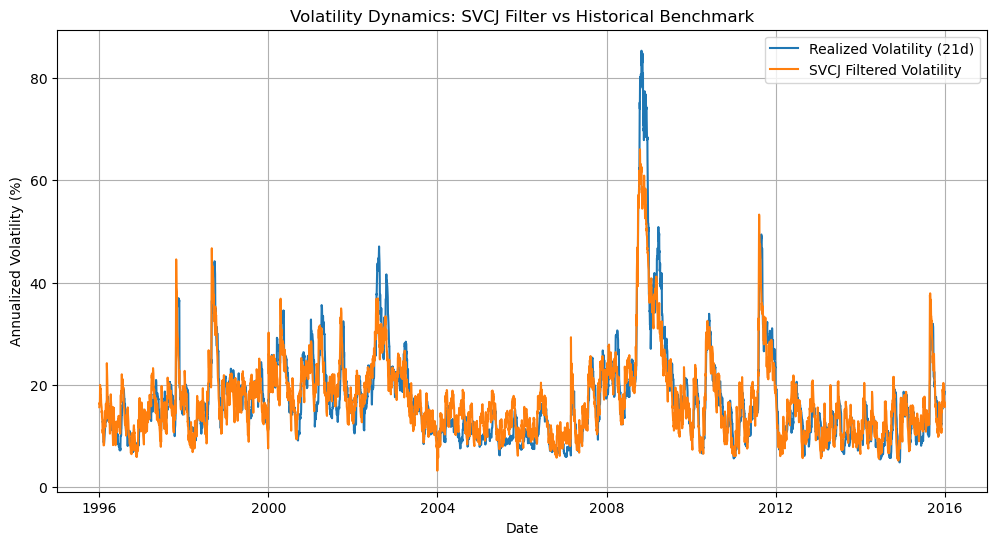

In [145]:
# Benchmark: Realized Volatility Estimation

TRADING_DAYS = 252
WINDOW = 21
daily_vol = data_return_based['R_t'].rolling(window=WINDOW).std()
rv_annualized = daily_vol * np.sqrt(TRADING_DAYS) * 100
df_rv = pd.DataFrame({'RV': rv_annualized.dropna()})

# Model: SVCJ Filtered Volatility Extraction
# Extracting latent variance state E[V_t | Y_{1:t}] from particle history
filtered_var = np.array([m['mean'][0] for m in pf_SVCJ.summaries.moments])
svcj_vol = np.sqrt(filtered_var) * 100
svcj_dates = data_return_based['R_t'].index[-len(svcj_vol):]

# Visualization
plt.figure(figsize=(12, 6))

# Benchmark
plt.plot(df_rv.index, df_rv['RV'], label=f'Realized Volatility ({WINDOW}d)')

# Model Output
plt.plot(svcj_dates, svcj_vol, label='SVCJ Filtered Volatility')


plt.title('Volatility Dynamics: SVCJ Filter vs Historical Benchmark')
plt.ylabel('Annualized Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

In [146]:
# Parameters for variance estimation
n_runs = 20
n_particles_test = 30000

# Parallel execution for efficiency
results = multiSMC(
    fk=fk_model,
    N=n_particles_test,
    nruns=n_runs,
    nprocs=0,
    resampling='systematic',
    ESSrmin=0.5,
    store_history=False,
    out_func=lambda pf: pf.logLt  # Direct extraction
)

# Retrieve LogLikelihoods from output dict
log_likelihoods = [res['output'] for res in results]

# Compute statistics
mean_ll_SVCJ = np.mean(log_likelihoods)
std_dev_SVCJ = np.std(log_likelihoods)

print(f"Mean LogLt SV: {mean_ll_SVCJ:.4f}")
print(f"Std Dev SV:    {std_dev_SVCJ:.4f}")
print(f"Var SV:    {std_dev_SVCJ**2:.4f}")

Mean LogLt SV: 16161.5764
Std Dev SV:    0.9104
Var SV:    0.8288


Let's try with a SV

In [147]:
annuals_fixed_SV_params = {
    "kappa": 6.4802,
    "theta": 0.0339,
    "sigma": 0.5121,
    "rho": -0.7886,
    "eta_s": 2.3818,
    # SVCJ params set to 0.0 to collapse into SV model
    "mu_s": 0.0,
    "sigma_s": 0.0,
    "lbd": 0.0,
    "mu_v": 0.0,
    "rho_j": 0.0,
    "delta": 0.0
}

In [148]:
model_SV = SVCJ_Model(r_vec=r_vector, dt=dt, **annuals_fixed_SV_params)
fk_model_SV = ssm.Bootstrap(ssm=model_SV, data=data_y)
n_particles = 20000
pf_SV = particles.SMC(
    fk=fk_model_SV,
    N=n_particles,
    resampling='systematic',
    ESSrmin=0.5,
    store_history=False,
    collect=[collectors.Moments()]
)
pf_SV.run()

In [149]:
log_likelihood_SV = pf_SV.logLt
print(f"Log-Vraisemblance Marginale Estimée (log L_T): {log_likelihood_SV:.4f}")

Log-Vraisemblance Marginale Estimée (log L_T): 16134.9741


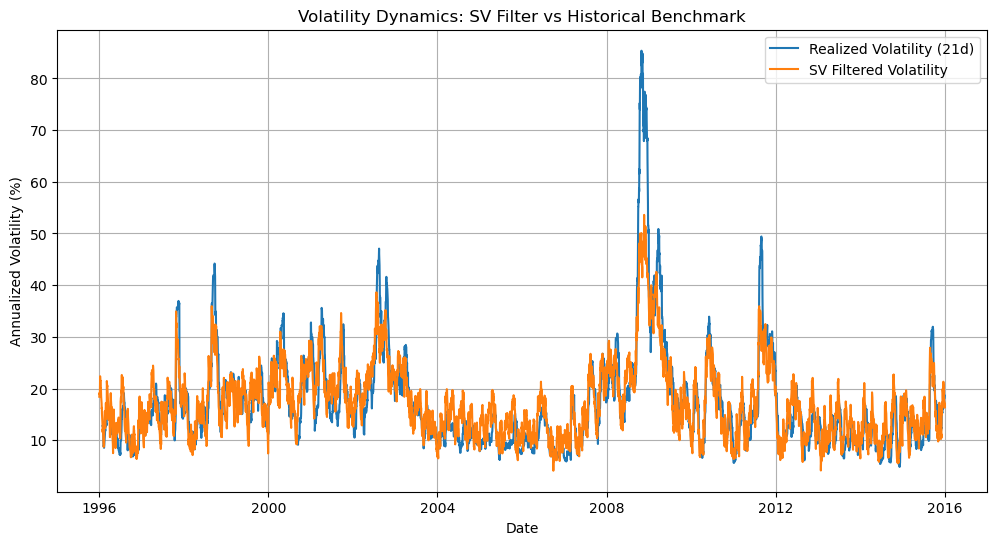

In [150]:
# Benchmark: Realized Volatility Estimation

TRADING_DAYS = 252
WINDOW = 21
daily_vol = data_return_based['R_t'].rolling(window=WINDOW).std()
rv_annualized = daily_vol * np.sqrt(TRADING_DAYS) * 100
df_rv = pd.DataFrame({'RV': rv_annualized.dropna()})

# Model: SV Filtered Volatility Extraction
filtered_var = np.array([m['mean'][0] for m in pf_SV.summaries.moments])
sv_vol = np.sqrt(filtered_var) * 100
sv_dates = data_return_based['R_t'].index[-len(sv_vol):]

# Visualization
plt.figure(figsize=(12, 6))

# Benchmark
plt.plot(df_rv.index, df_rv['RV'], label=f'Realized Volatility ({WINDOW}d)')

# Model Output
plt.plot(sv_dates, sv_vol, label='SV Filtered Volatility')


plt.title('Volatility Dynamics: SV Filter vs Historical Benchmark')
plt.ylabel('Annualized Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

In [151]:
# Parameters for variance estimation
n_runs = 20
n_particles_test = 30000

# Parallel execution for efficiency
results = multiSMC(
    fk=fk_model_SV,
    N=n_particles_test,
    nruns=n_runs,
    nprocs=0,
    resampling='systematic',
    ESSrmin=0.5,
    store_history=False,
    out_func=lambda pf: pf.logLt  # Direct extraction
)

# Retrieve LogLikelihoods from output dict
log_likelihoods = [res['output'] for res in results]

# Compute statistics
mean_ll_SV = np.mean(log_likelihoods)
std_dev_SV = np.std(log_likelihoods)

print(f"Mean LogLt SV: {mean_ll_SV:.4f}")
print(f"Std Dev SV:    {std_dev_SV:.4f}")
print(f"Var SV:    {std_dev_SV**2:.4f}")

Mean LogLt SV: 16133.9522
Std Dev SV:    1.5134
Var SV:    2.2905


Fct for viz and perf metrics

In [152]:
def analyze_pmmh_run(pmmh_algo, burn_in_ratio=0.2):
    """
    Standardizes post-processing for PMMH runs.
    Extracts chain, removes burn-in, reports stats, and plots traces.
    
    Args:
        pmmh_algo: The executed PMMH object (from particles library).
        burn_in_ratio (float): Fraction of the chain to discard (0.0 to 1.0).
        
    Returns:
        pd.DataFrame: The cleaned posterior samples (ready for ESS calculation).
    """
    
    # 1. Performance Metric (Acceptance Rate)
    print(f"Final Acceptance Rate: {pmmh_algo.acc_rate:.2%}")
    
    # 2. Data Extraction
    # Convert structured array to DataFrame directly
    chain_data = pmmh_algo.chain.theta
    df_full = pd.DataFrame(chain_data)
    
    # 3. Burn-in Removal
    n_total = len(df_full)
    burn_in_idx = int(n_total * burn_in_ratio)
    df_posterior = df_full.iloc[burn_in_idx:].copy()
    
    print(f"Analysis based on {len(df_posterior)} posterior samples (Discarded first {burn_in_idx})")
    
    # 4. Visualization: Traceplots
    n_params = len(df_posterior.columns)
    
    # Dynamic figure size based on parameter count
    fig, axes = plt.subplots(nrows=n_params, ncols=1, figsize=(10, 2.5 * n_params), sharex=True)
    fig.suptitle('MCMC Traceplots (Convergence & Mixing)', fontsize=14, y=0.99)
    
    # Ensure axes is iterable even if there's only 1 parameter
    if n_params == 1:
        axes = [axes]
        
    for i, param in enumerate(df_posterior.columns):
        ax = axes[i]
        # Plot raw values
        ax.plot(df_posterior[param].values, lw=1.0, alpha=0.8)
        
        # Styling
        ax.set_ylabel(param, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Add a visual mean line
        mean_val = df_posterior[param].mean()
        ax.axhline(mean_val, color='red', linestyle=':', alpha=0.5, label=f"Mean: {mean_val:.4f}")
        ax.legend(loc='upper right', fontsize='small')

    plt.xlabel("Iterations (Post Burn-in)")
    plt.tight_layout()
    plt.show()
    
    return df_posterior

Let's assume div yield = 0

PMMH on SV parameters with Jump parameters fixed

Goal : estimate distrib of the SV params

In [153]:
# Fixed Jump parameters (strictly from Table A1)
fixed_jump_params = {
    'lbd': 0.0,
    'mu_s':  0.0,
    'sigma_s': 0.0,
    'mu_v':   0.0,
    'rho_j': 0.0,
    'delta':  0.0
}

# Initial theta for the chain start
theta0 = {
    'kappa': 6.4802,
    'theta': 0.0339,
    'sigma': 0.5121,
    'rho':  -0.7886,
    'eta_s': 2.3818
}

In [154]:
# We use 'partial' to freeze the fixed parameters 
from functools import partial
SVCJ_Frozen = partial(
    SVCJ_Model, 
    r_vec=r_vector, 
    dt=dt, 
    **fixed_jump_params 
)

Let's implement a naive Prior distribution for SV parameters to check if our algo can found the right param with a bad ini. let's use the config of the paper (p15)

Implement kho adistrib

In [155]:
class LogitNormalBounded(dists.ProbDist):
    """
    Generalized Logit-Normal distribution on a bounded interval (a, b).
    
    Transformation:
        X = ln( (Y - a) / (b - Y) ) ~ Normal(loc, scale^2)
        
    This allows setting priors on parameters bounded in (a, b) by defining 
    a Normal belief on their logit transformation.
    
    Used in Dufays et al. (2022) for:
    - Rho (Correlation): a=-1, b=1
    - Lambda (Jump intensity): a=0.5, b=252
    
    Parameters
    ----------
    loc: float
        Mean of the underlying Normal distribution.
    scale: float
        Standard deviation of the underlying Normal distribution.
    a: float
        Lower bound of the physical parameter.
    b: float
        Upper bound of the physical parameter.
    """

    def __init__(self, loc=0.0, scale=1.0, a=0.0, b=1.0):
        self.loc = loc
        self.scale = scale
        self.a = a
        self.b = b

    def rvs(self, size=None):
        # 1. Sample X from Normal(loc, scale)
        x = random.normal(loc=self.loc, scale=self.scale, size=self.shape(size))
        
        # 2. Inverse transformation (Sigmoid scaled)
        # Y = a + (b - a) * (1 / (1 + exp(-x)))
        return self.a + (self.b - self.a) * (1.0 / (1.0 + np.exp(-x)))

    def logpdf(self, y):
        # Ensure array
        y = np.array(y)
        
        # 1. Bounds check
        out_of_bounds = (y <= self.a) | (y >= self.b)
        
        # 2. Numerical safety (clip slightly inside interval to avoid log(0))
        # We assume y is float64
        eps = 1e-9
        y_safe = np.clip(y, self.a + eps, self.b - eps)
        
        # 3. Transform to X space: X = ln( (y - a) / (b - y) )
        val_x = np.log((y_safe - self.a) / (self.b - y_safe))
        
        # 4. Log-density of X under Normal
        log_prob_x = stats.norm.logpdf(val_x, loc=self.loc, scale=self.scale)
        
        # 5. Jacobian Adjustment
        # dX/dY = (b - a) / ((y - a)(b - y))
        # Log-Jac = ln(b-a) - ln(y - a) - ln(b - y)
        jac = np.log(self.b - self.a) - np.log(y_safe - self.a) - np.log(self.b - y_safe)
        
        lp = log_prob_x + jac
        
        # Apply bounds mask
        if np.any(out_of_bounds):
             # Handle scalar vs vector nicely
            if lp.ndim == 0: return -np.inf
            lp[out_of_bounds] = -np.inf
            
        return lp

    def ppf(self, u):
        # Inverse CDF
        x = stats.norm.ppf(u, loc=self.loc, scale=self.scale)
        return self.a + (self.b - self.a) * (1.0 / (1.0 + np.exp(-x)))

Lets' try to reduce the prior to avoid value wich are impossible for our S&P data

In [156]:
SV_prior_paper_bounded = dists.StructDist({
    # Diffusion parameters with flat (uninformative) priors
    # We bounded to avoid non sense ini
    'kappa':   dists.Uniform(1.0, 10.0),#In the litterature never above 10 and above 1
    'theta':   dists.Uniform(0.0001, 0.2), #Litterature never above 0.05
    'sigma':   dists.Uniform(0.01, 1.5),#never above 1
    'eta_s':   dists.Uniform(0.0001, 5.0),#Risk premia >0
    'rho':     LogitNormalBounded(loc=-1.5, scale=0.5, a=-1.0, b=1.0),
})
# Strategic reset: Simple identity scaled by gamma
# Ensures unbiased local exploration around the 16161.58 peak


gamma = 0.1 
rw_cov_pure_naive = np.eye(5) * gamma

In [158]:
# PMMH Algorithm Setup
n_particles = 30000  # Particle count for variance control
n_iterations = 500

pmmh_algorithm_est_theta_SV_Naive_ini_bounded = mcmc.PMMH(
    ssm_cls=SVCJ_Frozen,       # The pre configured model class
    prior=SV_prior_paper_bounded,           # Parameters to be estimated
    data=data_y,               # Log returns data
    Nx=n_particles,                  # Number of particles for likelihood estimation
    smc_options={              # Internal Particle Filter settings
        'resampling': 'systematic',
        'ESSrmin': 0.5,
        'store_history': False
    },
    niter=n_iterations,
    #theta0=theta0,
    #scale=0.75,
    adaptive = True,
    #rw_cov = rw_cov_pure_naive,
    verbose = 100
)
pmmh_algorithm_est_theta_SV_Naive_ini_bounded.run()

Iteration 0, eta_s=1.6823570312757063, kappa=8.70454120838784, rho=-0.5962683798011796, sigma=1.4965465826773872, theta=0.1141626142498656
Iteration 5, acc. rate=0.000, eta_s=1.6823570312757063, kappa=8.70454120838784, rho=-0.5962683798011796, sigma=1.4965465826773872, theta=0.1141626142498656
Iteration 10, acc. rate=0.000, eta_s=1.6823570312757063, kappa=8.70454120838784, rho=-0.5962683798011796, sigma=1.4965465826773872, theta=0.1141626142498656
Iteration 15, acc. rate=0.067, eta_s=1.6265994189745612, kappa=8.630818646698957, rho=-0.6642758294947453, sigma=1.4577772590050646, theta=0.08003967223156273
Iteration 20, acc. rate=0.050, eta_s=1.6265994189745612, kappa=8.630818646698957, rho=-0.6642758294947453, sigma=1.4577772590050646, theta=0.08003967223156273
Iteration 25, acc. rate=0.080, eta_s=1.601504719385028, kappa=8.609995116041649, rho=-0.6529224008885669, sigma=1.4201099571412095, theta=0.1115696059858103
Iteration 30, acc. rate=0.200, eta_s=1.6618548989162882, kappa=8.52519675

Final Acceptance Rate: 22.24%
Analysis based on 400 posterior samples (Discarded first 100)


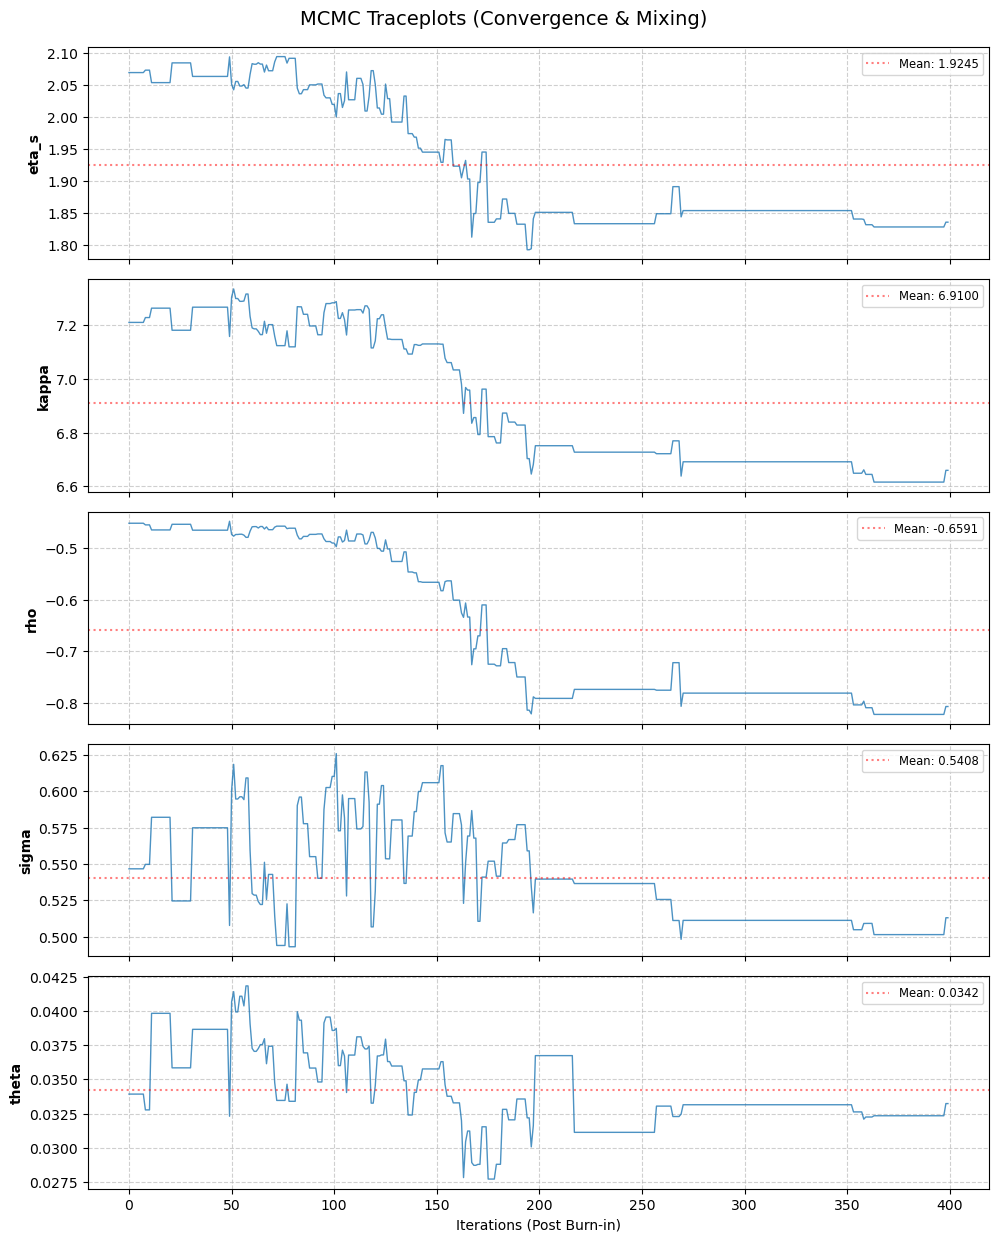

In [159]:
df_sv_naive_ini=analyze_pmmh_run(pmmh_algorithm_est_theta_SV_Naive_ini_bounded,burn_in_ratio=0.2)

Test V2 PMMH Full

Distrib as atrcicle with ini for SV as we juste found

In [160]:
# Full SVCJ Prior:Uniform for jumps and diffusion
full_prior_article = dists.StructDist({
    # Diffusion Block
    'kappa':   dists.Uniform(1.0, 10.0),#In the litterature never above 10 and above 1
    'theta':   dists.Uniform(0.0001, 0.2), #Litterature never above 0.05
    'sigma':   dists.Uniform(0.01, 1.5),#never above 1
    'eta_s':   dists.Uniform(0.0001, 5.0),#Risk premia >0
    'rho':     LogitNormalBounded(loc=-1.5, scale=0.5, a=-1.0, b=1.0),
    
    # Jump Block: Flat priors over physical supports (Dufays Section 3.2)
    'lbd':     LogitNormalBounded(loc=-6.0, scale=1.0, a=0.5, b=252.0), # Annual intensity
    'rho_j':   LogitNormalBounded(loc=-0.5, scale=0.5, a=-1.0, b=1.0),
    'mu_s':      dists.Uniform(a=np.negative(0.2), b=0.0), 
    'sigma_s':   dists.Uniform(a=0.0001, b=0.2), 
    'mu_v':      dists.Uniform(a=0.0001, b=0.3)  # Vol jump size
})

In [171]:
# Fixed model definition with delta=0.0
SVCJ_Full = partial(
    SVCJ_Model, 
    r_vec=r_vector, 
    dt=dt,
    delta=0.0
)

sv_means = df_sv_naive_ini.mean()
theta0_SV = {
    'kappa':   sv_means['kappa'],
    'theta':   sv_means['theta'],
    'sigma':   sv_means['sigma'],
    'rho':     sv_means['rho'],
    'eta_s':   sv_means['eta_s']
}
safe_jumps = {
    'lbd':     full_prior_article.laws['lbd'].rvs(size=1)[0],
    'rho_j':   full_prior_article.laws['rho_j'].rvs(size=1)[0],
    'mu_s':    full_prior_article.laws['mu_s'].rvs(size=1)[0],
    'sigma_s': full_prior_article.laws['sigma_s'].rvs(size=1)[0],
    'mu_v':    full_prior_article.laws['mu_v'].rvs(size=1)[0]
}

theta0_init = np.zeros(1, dtype=full_prior_article.dtype)

for key, value in theta0_SV.items():
    theta0_init[key] = value

for key, value in safe_jumps.items():
    theta0_init[key] = value
theta0_init

array([(1.9245186, 6.91001048, 1.20957095, -0.15239783, 0.14761525, -0.65906581, -0.06235111, 0.54076455, 0.04350998, 0.03420388)],
      dtype=[('eta_s', '<f8'), ('kappa', '<f8'), ('lbd', '<f8'), ('mu_s', '<f8'), ('mu_v', '<f8'), ('rho', '<f8'), ('rho_j', '<f8'), ('sigma', '<f8'), ('sigma_s', '<f8'), ('theta', '<f8')])

Let's give a naive ini cov matrix

In [172]:
# Tuning parameter: 10%
gamma = 0.1

# 1. Definition of Base Metrics (Characteristic Size)
# - Uniforms: Width (b - a)
# - LogitNormals: The latent Scale (sigma of the underlying normal)
base_metrics = [
    9.0,         # kappa (Uniform): 10 - 1
    0.2,         # theta (Uniform): 0.2 - 0.0001
    1.5,         # sigma (Uniform): 1.5 - 0.01
    5.0,         # eta_s (Uniform): 5 - 0.0001
    
    0.5,         # rho (LogitNormal): we use the latent Scale (0.5)
    1.0,         # lbd (LogitNormal): we use the latent Scale (1.0)
    0.5,         # rho_j (LogitNormal): we use the latent Scale (0.5)
    
    0.2,         # mu_s (Uniform): 0 - (-0.2)
    0.2,         # sigma_s (Uniform): 0.2 - 0.0001
    0.3          # mu_v (Uniform): 0.3 - 0.0001
]

# 2. Compute the RW Variance
# Formula: Variance = (Base_Metric * gamma)^2
cov_diag = [(val * gamma)**2 for val in base_metrics]

# 3. Create Matrix
rw_cov_full = np.diag(cov_diag)

In [232]:
mcmc.PMMH?

Init signature:
mcmc.PMMH(
    niter=10,
    verbose=0,
    ssm_cls=None,
    smc_cls=<class 'particles.core.SMC'>,
    prior=None,
    data=None,
    smc_options=None,
    fk_cls=<class 'particles.state_space_models.Bootstrap'>,
    Nx=100,
    theta0=None,
    adaptive=True,
    scale=1.0,
    rw_cov=None,
)
Docstring:     
Particle Marginal Metropolis Hastings.

PMMH is class of Metropolis samplers where the intractable likelihood of
the considered state-space model is replaced by an estimate obtained from
a particle filter.
Init docstring:
Parameters
----------
niter: int
    number of iterations
verbose: int (default=0)
    print some info every `verbose` iterations (never if 0)
ssm_cls: StateSpaceModel class
    the considered parametric class of state-space models
smc_cls: class (default: particles.SMC)
    SMC class
prior: StructDist
    the prior
data: list-like
    the data
smc_options: dict
    options to pass to class SMC
fk_cls: (default=ssms.Bootstrap)
    FeynmanKac clas

In [175]:
# PMMH Execution Setup
n_particles = 30000  
n_iterations = 500

pmmh_full_unif = mcmc.PMMH(
    ssm_cls=SVCJ_Full,
    prior=full_prior_article,
    data=data_y,
    Nx=n_particles,
    smc_options={
        'resampling': 'systematic',
        'ESSrmin': 0.5,
        'store_history': False
    },
    niter=n_iterations,
    adaptive=True,
    verbose=100,
    theta0=theta0_init,
    scale=1.5,
    rw_cov=rw_cov_full
)
pmmh_full_unif.run()

Iteration 0, eta_s=1.7952186064441307, kappa=6.453073590555481, lbd=1.0985550795875454, mu_s=-0.063572852166034, mu_v=0.13677233065302538, rho=-0.6064637340642349, rho_j=-0.06227565075617018, sigma=0.5010473748447711, sigma_s=0.044337321449767486, theta=0.029005567781775994
Iteration 5, acc. rate=0.000, eta_s=1.7952186064441307, kappa=6.453073590555481, lbd=1.0985550795875454, mu_s=-0.063572852166034, mu_v=0.13677233065302538, rho=-0.6064637340642349, rho_j=-0.06227565075617018, sigma=0.5010473748447711, sigma_s=0.044337321449767486, theta=0.029005567781775994
Iteration 10, acc. rate=0.100, eta_s=1.9951196788105703, kappa=7.198444436794863, lbd=1.223206547448043, mu_s=-0.014911555558894188, mu_v=0.15400313659802284, rho=-0.6729367105443897, rho_j=-0.07230029251587282, sigma=0.5597159758717632, sigma_s=0.047980739147198, theta=0.029751660787809546
Iteration 15, acc. rate=0.133, eta_s=1.794653561644751, kappa=7.018138141883291, lbd=1.1847300605084283, mu_s=-0.036197025125062066, mu_v=0.1

Final Acceptance Rate: 30.46%
Analysis based on 400 posterior samples (Discarded first 100)


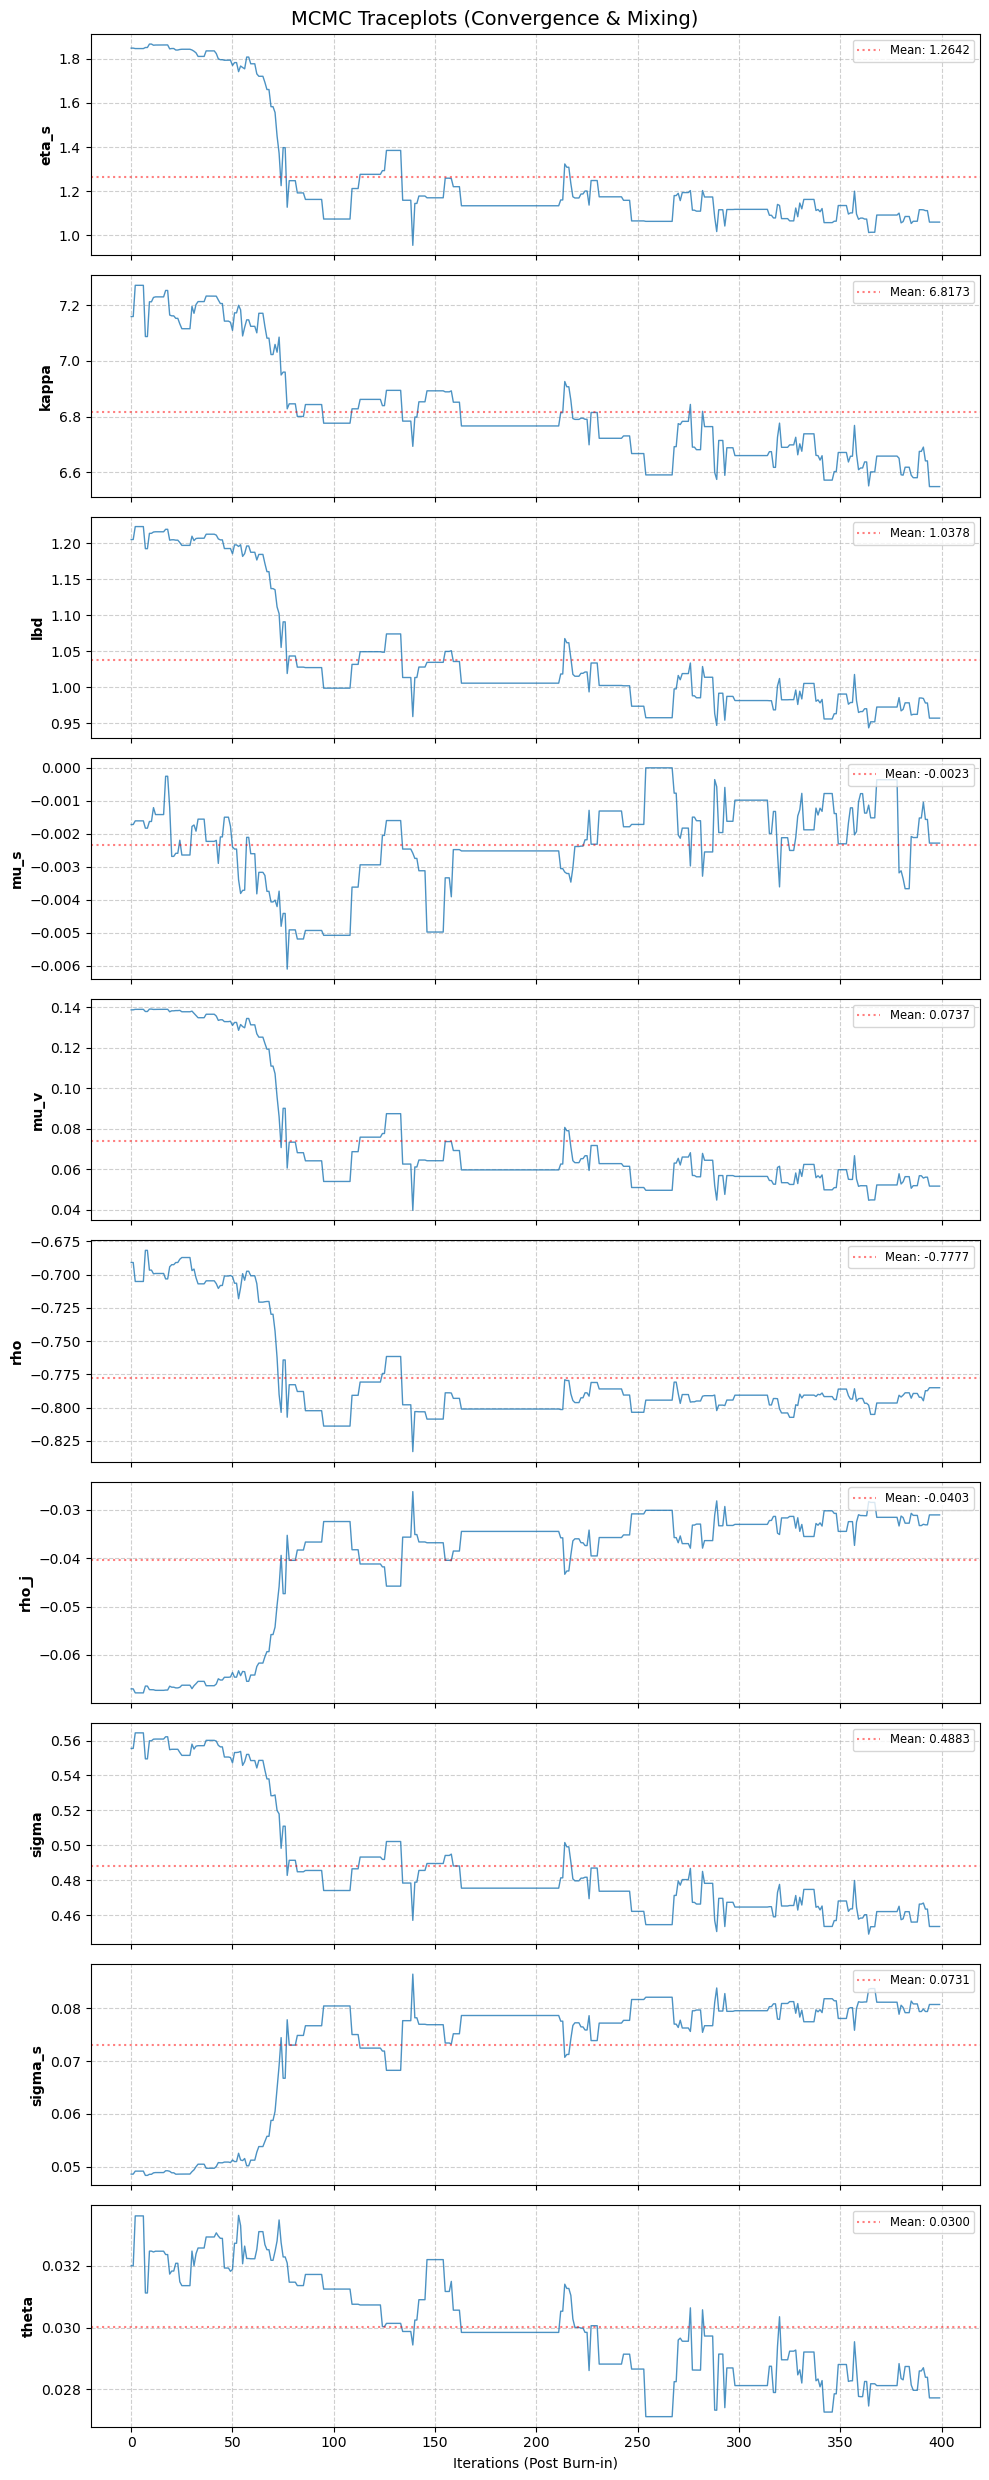

In [176]:
df_full=analyze_pmmh_run(pmmh_full_unif)

In [177]:
import numpy as np

# Extraction of theta found with PMMH from the naive Random Walk run
# We calculate the mean of the posterior distributions (discarding burn-in)
theta_pmmh = df_full.mean().to_dict()
theta_pmmh['delta'] = 0.0

# Particle Filter setup for variance estimation
n_runs = 20
n_particles_test = 30000

# Bootstrap
model_validation = SVCJ_Model(r_vec=r_vector, dt=dt, **theta_pmmh)
fk_validation = ssm.Bootstrap(ssm=model_validation, data=data_y)

# Execution of multiSMC to assess the approximation error
results = multiSMC(
    fk=fk_validation,
    N=n_particles_test,
    nruns=n_runs,
    nprocs=4,
    resampling='systematic', 
    ESSrmin=0.5,
    out_func=lambda pf: pf.logLt 
)

# Statistical metrics extraction
log_likelihoods = [res['output'] for res in results]
variance_log_lik = np.var(log_likelihoods)
mean_log_lik = np.mean(log_likelihoods)
print(f"Mean Log-Likelihood:  {mean_log_lik:.4f}")
print(f"Variance : {variance_log_lik:.4f}")

Mean Log-Likelihood:  16148.9045
Variance : 0.9849


In [ ]:
def run_smc_convergence_study(n_particles_range, n_runs_check, theta_pmmh):
    """
    Performs a variance analysis of the Log-Likelihood estimator across a range of N.
    Aims to verify the O(1/N) convergence rate and identify the optimal N for PMMH.
    """
    variance_results = []
    
    print(f"Starting SMC convergence study with {n_runs_check} runs per N step...")

    for N_val in n_particles_range:
        # Model instantiation at the PMMH posterior mean (theta found with PMMH)
        # delta is assumed to be handled within theta_pmmh dictionary
        model_study = SVCJ_Model(r_vec=r_vector, dt=dt, **theta_pmmh)
        fk_study = ssm.Bootstrap(ssm=model_study, data=data_y)
        
        # Sequential Monte Carlo multi-runs
        # Assessing approximation error for Log-Likelihood [Slide 50]
        smc_outputs = multiSMC(
            fk=fk_study,
            N=N_val,
            nruns=n_runs_check,
            nprocs=2,
            resampling='systematic', 
            ESSrmin=0.5,
            out_func=lambda pf: pf.logLt 
        )
        
        # Variance computation: Var[log p_hat(y|theta)]
        ll_values = [res['output'] for res in smc_outputs]
        current_var = np.var(ll_values)
        variance_results.append(current_var)
        
        print(f"N = {N_val} | Variance = {current_var:.4f}")

    # Visualization of results vs theoretical thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(n_particles_range, variance_results, marker='o', color='blue', label='Empirical Variance')

    # Reference thresholds from Course & Project constraints
    plt.axhline(y=1.0, color='red', linestyle='--', label='Critical Threshold (1.0)')
    plt.axhline(y=gamma, color='green', linestyle=':', label=f'Gamma Threshold ({gamma})')

    plt.xlabel('Number of Particles (N)')
    plt.ylabel('Variance of Log-Likelihood')
    plt.title('SMC Efficiency: Log-Likelihood Variance Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return variance_results

Starting SMC convergence study with 20 runs per N step...
N = 5000 | Variance = 4.1729
N = 10000 | Variance = 1.9016
N = 15000 | Variance = 1.6324
N = 20000 | Variance = 1.7708
N = 25000 | Variance = 0.6677
N = 30000 | Variance = 0.6266
N = 35000 | Variance = 1.0604
N = 40000 | Variance = 1.0227
N = 45000 | Variance = 1.0459
N = 50000 | Variance = 0.6620


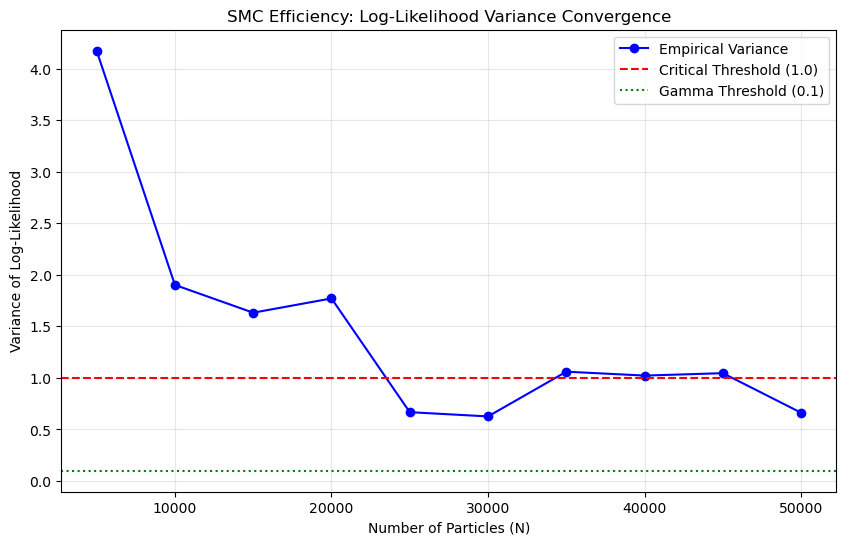

In [179]:
theta_final = df_full.mean().to_dict()
theta_final['delta'] = 0.0
results = run_smc_convergence_study(np.linspace(5000, 50000, 10, dtype=int).tolist(), 20, theta_final)

Starting SMC convergence study with 20 runs per N step...
N = 5000 | Variance = 3.5596
N = 10000 | Variance = 3.5900
N = 15000 | Variance = 2.1725
N = 20000 | Variance = 1.9953
N = 25000 | Variance = 1.1154
N = 30000 | Variance = 1.1745
N = 35000 | Variance = 2.0493
N = 40000 | Variance = 0.5306
N = 45000 | Variance = 0.6669
N = 50000 | Variance = 0.9833


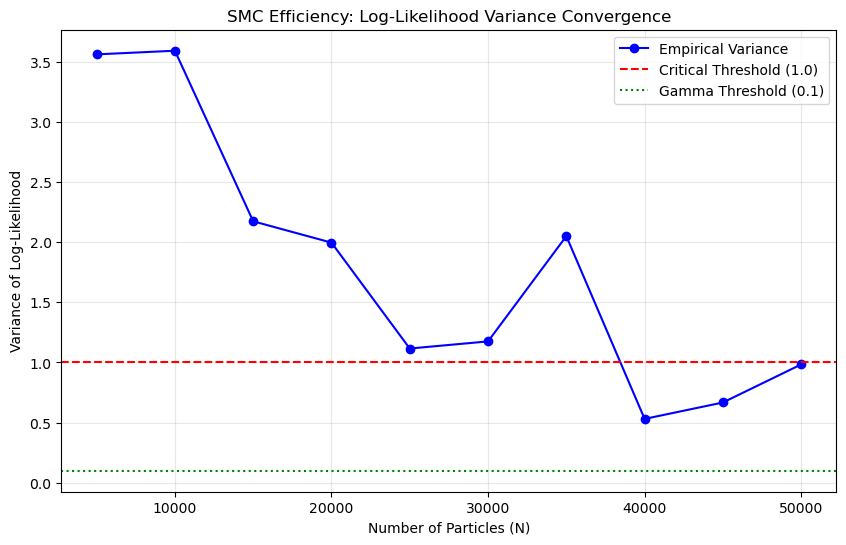

In [180]:
results = run_smc_convergence_study(np.linspace(5000, 50000, 10, dtype=int).tolist(), 20, annuals_fixed_params)

Test

In [227]:
import time

# Convert structured array to a dictionary for clean initialization
theta0_init = np.atleast_1d(pmmh_full_unif.chain.theta[-1])
# 2. Fast Run Configuration
n_particles_fast = 40000
n_iter_fast = 1000  


# 3. PMMH Initialization
pmmh_fast = mcmc.PMMH(
    ssm_cls=SVCJ_Full,
    prior=full_prior_article,
    data=data_y,
    Nx=n_particles_fast,
    smc_options={
        'resampling': 'systematic',
        'ESSrmin': 0.5,
        'store_history': False
    },
    niter=n_iter_fast,
    adaptive=True,
    #scale=2.38 / np.sqrt(len(theta0_init.dtype.names)),
    scale=2,
    verbose=100,
    theta0=theta0_init, 
    rw_cov=rw_cov_full,
)

# 4. Execution
start_time = time.time()
pmmh_fast.run()
print(f"Run finished in {(time.time() - start_time) / 3600:.2f} hours.")

Iteration 0, eta_s=0.937986177642904, kappa=6.525904737423245, lbd=0.9736864466093083, mu_s=-0.016744890932758973, mu_v=0.053744180642783856, rho=-0.780584095447628, rho_j=-0.02164651411732408, sigma=0.4539753397759426, sigma_s=0.08531681258250136, theta=0.029712908871096216
Iteration 10, acc. rate=0.000, eta_s=0.937986177642904, kappa=6.525904737423245, lbd=0.9736864466093083, mu_s=-0.016744890932758973, mu_v=0.053744180642783856, rho=-0.780584095447628, rho_j=-0.02164651411732408, sigma=0.4539753397759426, sigma_s=0.08531681258250136, theta=0.029712908871096216
Iteration 20, acc. rate=0.050, eta_s=0.9731025866803198, kappa=6.385239014046307, lbd=0.9627871394666024, mu_s=-0.009274011231333581, mu_v=0.05708474528681751, rho=-0.7751211621177949, rho_j=-0.021943190985366137, sigma=0.44440694017203325, sigma_s=0.08412900851485121, theta=0.030089832882718725
Iteration 30, acc. rate=0.100, eta_s=0.9508335079884125, kappa=6.396503474100403, lbd=0.9612520558325374, mu_s=-0.0008060132101151019

Final Acceptance Rate: 21.92%
Analysis based on 800 posterior samples (Discarded first 200)


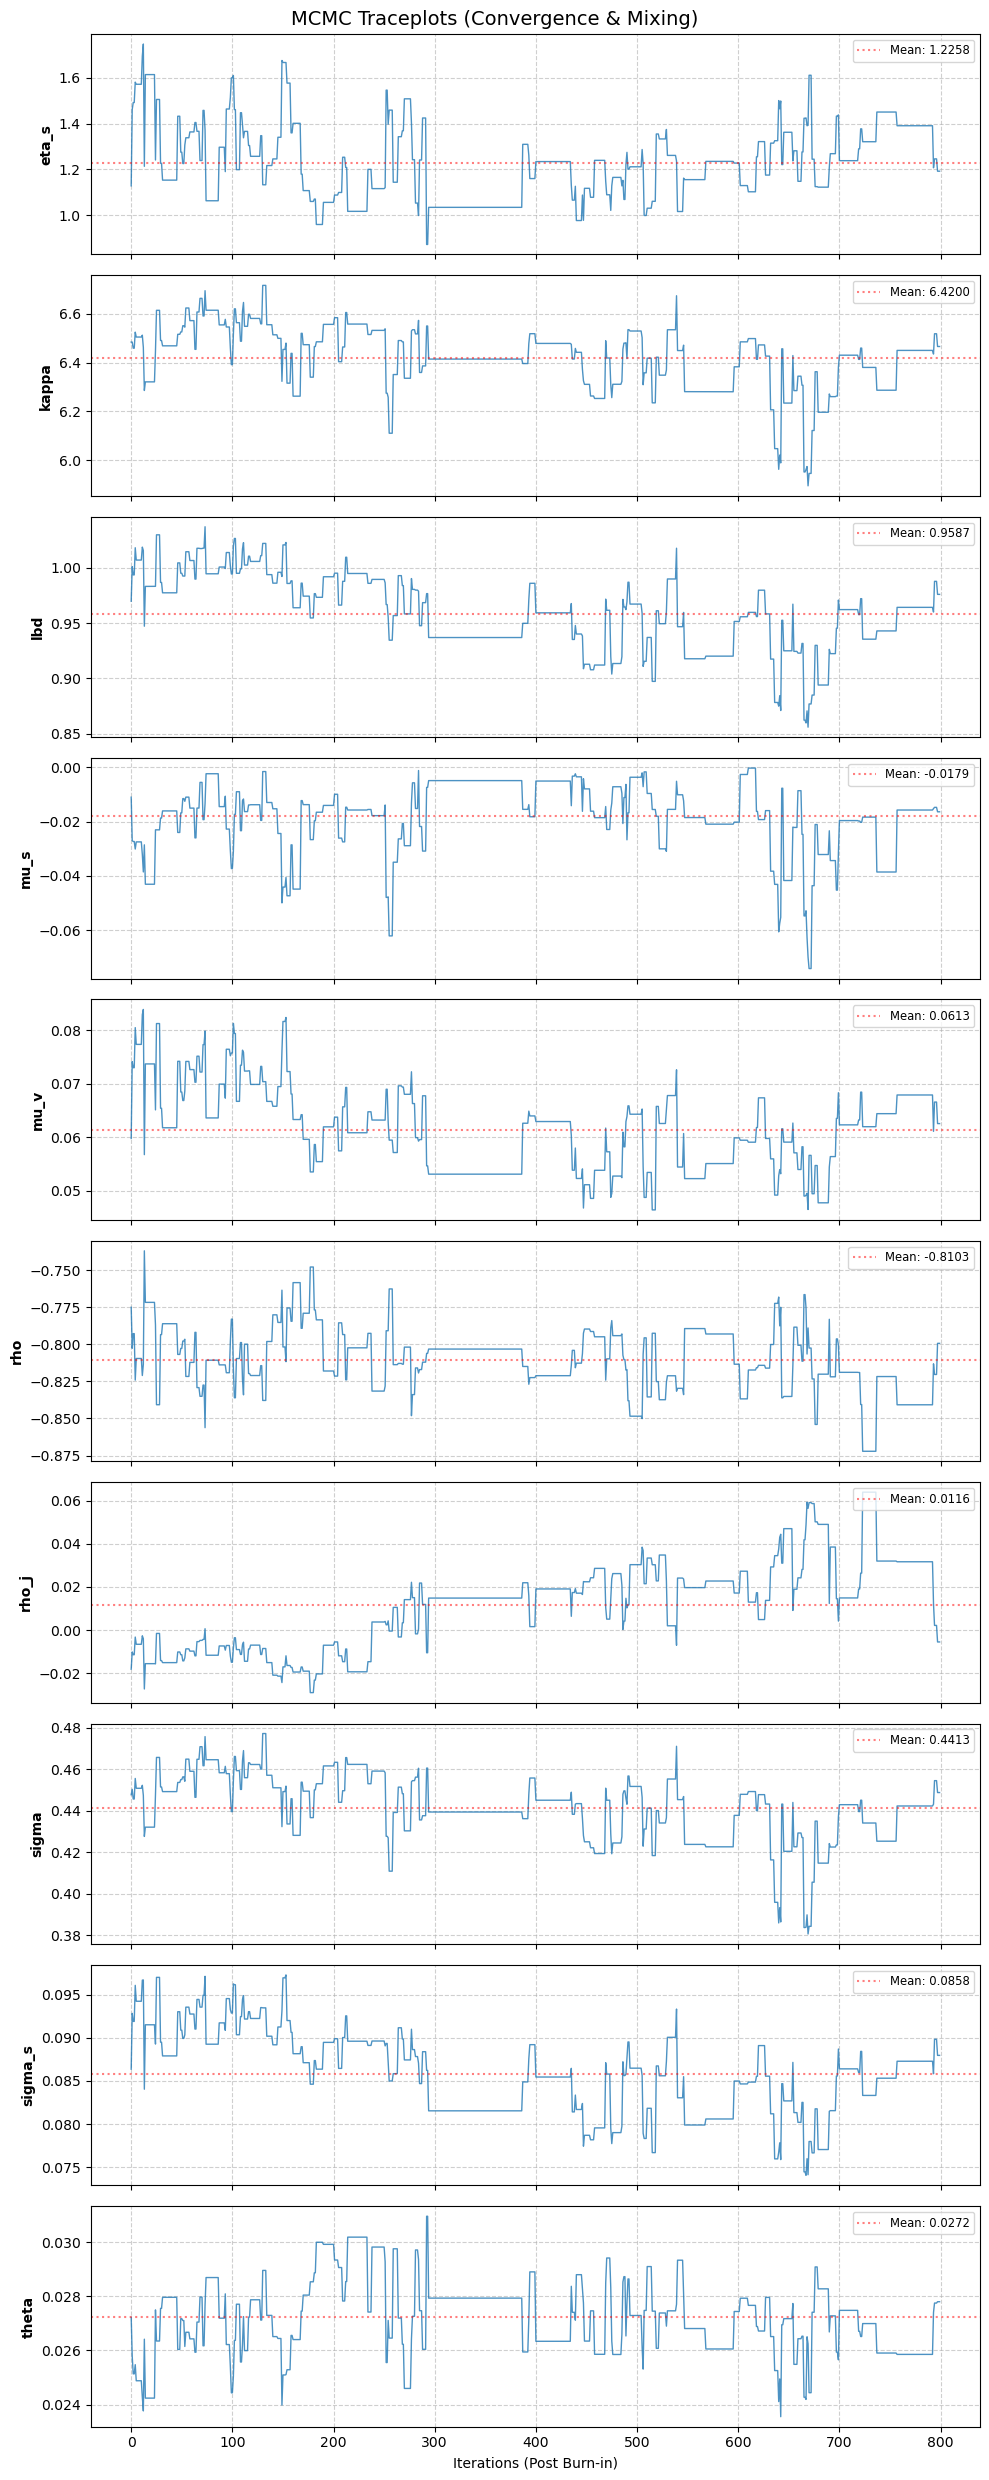

In [228]:
df_full_2=analyze_pmmh_run(pmmh_fast)

In [231]:
import numpy as np

# Extraction of theta found with PMMH from the naive Random Walk run
# We calculate the mean of the posterior distributions (discarding burn-in)
theta_pmmh = df_full_2.mean().to_dict()
theta_pmmh['delta'] = 0.0
theta_pmmh['rho_j'] = -0.0960

# Particle Filter setup for variance estimation
n_runs = 20
n_particles_test = 40000

# Bootstrap
model_validation = SVCJ_Model(r_vec=r_vector, dt=dt, **theta_pmmh)
fk_validation = ssm.Bootstrap(ssm=model_validation, data=data_y)

# Execution of multiSMC to assess the approximation error
results = multiSMC(
    fk=fk_validation,
    N=n_particles_test,
    nruns=n_runs,
    nprocs=0,
    resampling='systematic', 
    ESSrmin=0.5,
    out_func=lambda pf: pf.logLt 
)

# Statistical metrics extraction
log_likelihoods = [res['output'] for res in results]
variance_log_lik = np.var(log_likelihoods)
mean_log_lik = np.mean(log_likelihoods)
print(f"Mean Log-Likelihood:  {mean_log_lik:.4f}")
print(f"Variance : {variance_log_lik:.4f}")

Mean Log-Likelihood:  16150.4312
Variance : 0.9876


Starting SMC convergence study with 20 runs per N step...
N = 5000 | Variance = 5.9911
N = 10000 | Variance = 3.8536
N = 15000 | Variance = 2.3032
N = 20000 | Variance = 2.3466
N = 25000 | Variance = 2.5408
N = 30000 | Variance = 1.4231
N = 35000 | Variance = 0.7442
N = 40000 | Variance = 0.6626
N = 45000 | Variance = 0.8602
N = 50000 | Variance = 0.1568


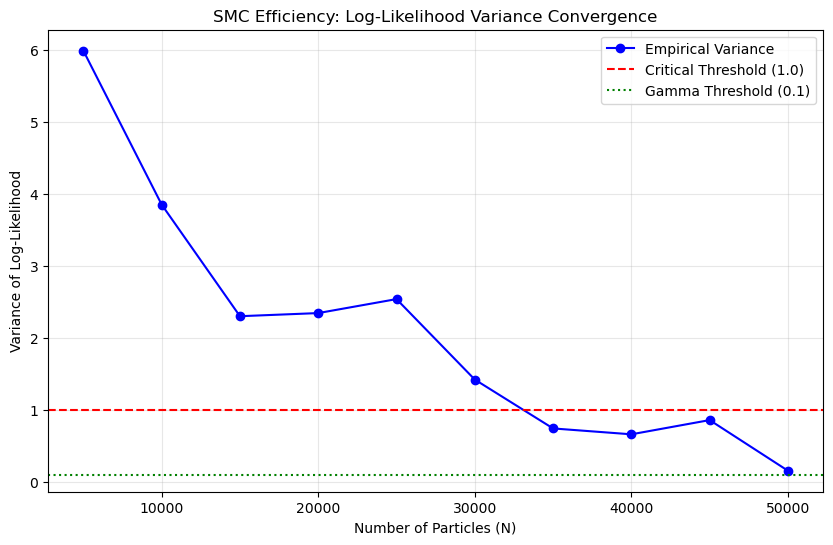

In [ ]:
theta_final = df_full_2.mean().to_dict()
theta_final['delta'] = 0.0
results = run_smc_convergence_study(np.linspace(5000, 50000, 10, dtype=int).tolist(), 20, theta_final)